Implementation of BiLSTM Model on AUD_USD(H1) prediction of the close price 1 hour ahead based on data of previous 24 hours

## 1. Data Preparation

### 1.1 Read in data file

In [1]:
## Mount google drive
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# import talib as ta

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

# from utils import series_to_supervised

## 2. Data Processing

In [3]:
data = pd.read_csv('AUD_USD_H1_withindicators.csv')

In [4]:
data

,open,high,low,close,upperband,middleband,lowerband,dema,ema,ht,...,cdlspinningtop,cdlstalledpattern,cdlsticksandwich,cdltakuri,cdltasukigap,cdlthrusting,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods
0,0.76660,0.76740,0.76620,0.76690,0.772125,0.767171,0.762217,0.765635,0.766812,0.766752,...,100,0,0,0,0,0,0,0,0,0
1,0.76700,0.76740,0.76680,0.76720,0.771836,0.767046,0.762255,0.765789,0.766843,0.766669,...,0,0,0,0,0,0,0,0,0,0
2,0.76720,0.76720,0.76630,0.76710,0.771420,0.766892,0.762363,0.765913,0.766864,0.766620,...,0,0,0,100,0,0,0,0,0,0
3,0.76720,0.76750,0.76620,0.76660,0.771182,0.766775,0.762368,0.765948,0.766843,0.766482,...,0,0,0,0,0,0,0,0,0,0
4,0.76660,0.76740,0.76630,0.76700,0.770581,0.766596,0.762610,0.766044,0.766855,0.766334,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102554,0.77218,0.77353,0.77122,0.77186,0.792204,0.781209,0.770214,0.773963,0.780610,0.786190,...,-100,0,0,0,0,0,0,0,0,0
102555,0.77190,0.77235,0.77064,0.77088,0.791442,0.780397,0.769351,0.773000,0.779832,0.785098,...,0,0,0,0,0,0,0,0,0,0
102556,0.77092,0.77152,0.76924,0.76947,0.791248,0.779687,0.768125,0.771955,0.779003,0.784054,...,0,0,0,0,0,0,0,0,0,0
102557,0.76944,0.77106,0.76926,0.77038,0.790680,0.778986,0.767292,0.771195,0.778313,0.783281,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train_split_frac = 0.8
val_split_frac = 0.9

train_split = int(train_split_frac * int(data.shape[0]))  ## end of train index (exclusive)
val_split = int(val_split_frac * int(data.shape[0]))      ## end of val index (exclusive)

In [6]:
step = 1
past = 24
future = 1
learning_rate = 0.00001
batch_size = 256
epochs = 1000

y = data[['close']]

### 2.1 Train - validation - test split

In [7]:
training_data = data[: train_split]
validation_data = data[train_split: val_split]
test_data = data[val_split:]

In [8]:
print('Shape of training_data:   ', training_data.shape)
print('Shape of validation_data: ', validation_data.shape)
print('Shape of test_data:       ', test_data.shape)

Shape of training_data:    (82047, 139)
Shape of validation_data:  (10256, 139)
Shape of test_data:        (10256, 139)


### 2.2 Standardisation


In [9]:
from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()

In [10]:
training_data = scaler.fit_transform(training_data)
validation_data = scaler.transform(validation_data)
test_data = scaler.transform(test_data)

### 2.3 Training dataset

In [11]:
train_y_start = past + future
train_y_end = train_y_start + train_split

In [12]:
x_train = training_data
y_train = y.iloc[train_y_start: train_y_end].values

In [13]:
sequence_length = int(past / step)

In [14]:
import tensorflow as tf
from tensorflow import keras

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

### 2.4 Validation dataset

In [15]:
val_y_start = train_y_end
val_y_end = train_y_start + val_split

In [16]:
x_val = validation_data
y_val = y.iloc[val_y_start: val_y_end].values

In [17]:
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

### 2.5 Test dataset

In [18]:
x_end = len(test_data) - past - future

In [19]:
test_y_start = val_y_end

In [20]:
x_test = test_data[: x_end]
y_test = y.iloc[test_y_start: ].values

In [30]:
dataset_test = keras.preprocessing.timeseries_dataset_from_array(
    x_test,
    y_test,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=1,
)

### 2.4 Input and output shape

In [22]:
for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 24, 139)
Target shape: (256, 1)


## 3. Experiment1: BiLSTM model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM
import keras

### 3.1 Training

In [24]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
outputs = layers.Bidirectional(layers.LSTM(200, return_sequences=True))(inputs)
outputs = layers.Bidirectional(layers.LSTM(200))(outputs)
outputs = keras.layers.Dense(1)(outputs)

model1 = keras.Model(inputs=inputs, outputs=outputs)
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 139)]         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 24, 400)           544000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 400)               961600    
_________________________________________________________________
dense (Dense)                (None, 1)                 401       
Total params: 1,506,001
Trainable params: 1,506,001
Non-trainable params: 0
_________________________________________________________________


In [25]:
path_checkpoint1 = "model_checkpoint_1.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint1,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model1.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/1000
321/321 [==============================] - 143s 432ms/step - loss: 0.0359 - val_loss: 5.7968e-04

Epoch 00001: val_loss improved from inf to 0.00058, saving model to model_checkpoint_1.h5
Epoch 2/1000
321/321 [==============================] - 142s 441ms/step - loss: 5.2849e-04 - val_loss: 4.7495e-04

Epoch 00002: val_loss improved from 0.00058 to 0.00047, saving model to model_checkpoint_1.h5
Epoch 3/1000
321/321 [==============================] - 150s 467ms/step - loss: 3.5791e-04 - val_loss: 2.8260e-04

Epoch 00003: val_loss improved from 0.00047 to 0.00028, saving model to model_checkpoint_1.h5
Epoch 4/1000
321/321 [==============================] - 143s 445ms/step - loss: 2.4880e-04 - val_loss: 1.7548e-04

Epoch 00004: val_loss improved from 0.00028 to 0.00018, saving model to model_checkpoint_1.h5
Epoch 5/1000
321/321 [==============================] - 137s 427ms/step - loss: 1.8296e-04 - val_loss: 1.0548e-04

Epoch 00005: val_loss improved from 0.00018 to 0.00011, s

321/321 [==============================] - 137s 428ms/step - loss: 1.2290e-04 - val_loss: 4.4266e-06

Epoch 00090: val_loss did not improve from 0.00000
Epoch 91/1000
321/321 [==============================] - 137s 425ms/step - loss: 1.1389e-04 - val_loss: 9.5810e-06

Epoch 00091: val_loss did not improve from 0.00000
Epoch 92/1000
321/321 [==============================] - 137s 427ms/step - loss: 6.1255e-05 - val_loss: 6.4188e-06

Epoch 00092: val_loss did not improve from 0.00000
Epoch 93/1000
321/321 [==============================] - 137s 427ms/step - loss: 4.4915e-05 - val_loss: 5.2274e-06

Epoch 00093: val_loss did not improve from 0.00000
Epoch 94/1000
321/321 [==============================] - 138s 429ms/step - loss: 4.1112e-05 - val_loss: 4.6794e-06

Epoch 00094: val_loss did not improve from 0.00000
Epoch 95/1000
321/321 [==============================] - 139s 434ms/step - loss: 4.0372e-05 - val_loss: 3.6878e-06

Epoch 00095: val_loss improved from 0.00000 to 0.00000, saving 

### 3.2 Train and validation losses

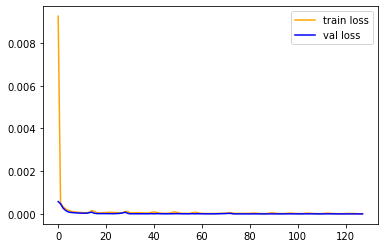

In [26]:
train_loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']
plt.plot(train_loss_1, label='train loss', c='orange')
plt.plot(val_loss_1, label='val loss', c='blue')
plt.legend(loc='best')
plt.show()

### 3.3 Prediction on test dataset

In [31]:
test_prediction_1 = []
test_actual = []
for x, y in dataset_test:
    test_actual.append(y[0][0])
    predict_res = model1.predict(x)[0][0]
    test_prediction_1.append(predict_res)
test_prediction_1 = np.array(test_prediction_1)
test_actual = np.array(test_actual)

### 3.4 Evaluation

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

rmse1 = mean_squared_error(test_actual, test_prediction_1, squared=False)
mape1 = mean_absolute_percentage_error(test_actual, test_prediction_1)
mae1 = mean_absolute_error(test_actual, test_prediction_1)

print('result evaluation')
print('RMSE: ', rmse1)
print('MAPE: ', mape1)
print('MAE:  ', mae1)

result evaluation
RMSE:  0.018008492713270922
MAPE:  0.020658885557900415
MAE:   0.014381844748139007


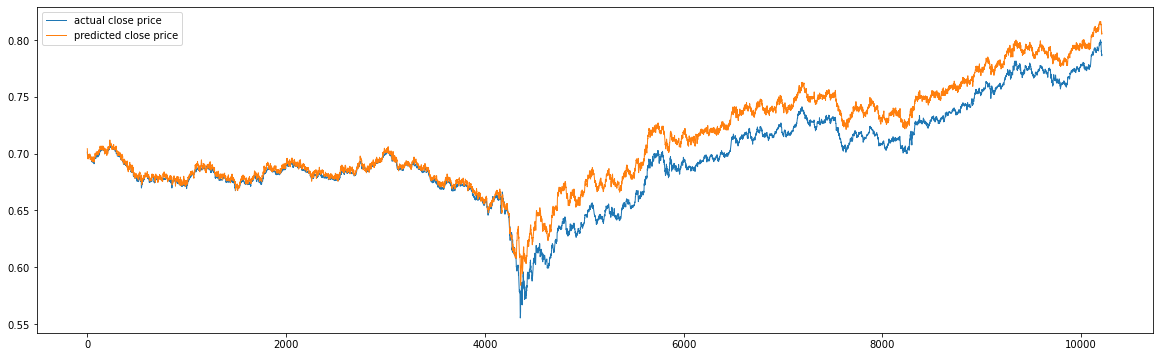

In [34]:
x_axis = [x for x in range(test_actual.shape[0])]
plt.figure(figsize=(20,6))

sns.lineplot(x=x_axis, y=test_actual, label='actual close price', linewidth=1)
sns.lineplot(x=x_axis, y=test_prediction_1, label='predicted close price', linewidth=1)
plt.legend()
plt.show()